In [1]:
%matplotlib inline

In [2]:
import xarray as xr
import xesmf as xe
import intake
import pprint 
import matplotlib.pyplot as plt
#import cartopy.crs as ccrs
import numpy as np
import cmocean
import pandas as pd

import xsd
import warnings
warnings.filterwarnings('ignore')

In [3]:
cat = intake.Catalog('/glade/u/home/jhamman/hap_data.yaml')
ds = cat['gmet_v2'].to_dask()


In [72]:
ds.attrs

{'history': 'Wed Oct 24 13:59:29 2018: ncks -4 -L 1 conus_daily_eighth_19800101_19801231.nc_001 -O conus_daily_eighth_19800101_19801231.nc_001',
 'NCO': 'netCDF Operators version 4.7.4 (http://nco.sf.net)',
 'institution': 'National Center fo Atmospheric Research (NCAR), Boulder, CO USA',
 'title': 'CONUS daily 12-km gridded ensemble precipitation and temperature dataset for 1980-2016',
 'source': 'Generated using version 1.1 of CONUS ensemble code base',
 'references': 'Newman et al. 2015: Gridded Ensemble Precipitation and Temperature Estimates for the Contiguous United States. J. Hydrometeorology'}

In [4]:
ds.pcp.load()

<xarray.DataArray 'pcp' (time: 13515, lat: 224, lon: 464)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.22094157, 0.1       , 0.21416904, ..., 0.37896878,
         0.        , 0.        ],
        [0.40075487, 0.1       , 0.18274564, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.32785207, 0.        ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.1       , 0.1       , 0.1       , ...,

In [5]:
# Querry CMIP6 data catalog for desired data
cat = intake.open_esm_datastore("/glade/u/home/yifanc/cmip6-downscalling/catalogs/glade-cmip6.json")
cat_h = cat.search(experiment_id = ['historical'], source_id = ['CESM2'], \
                 table_id = ['day'], variable_id = ['pr'], member_id = ['r1i1p1f1'])
src = cat_h.to_dataset_dict()
data = src['CMIP.NCAR.CESM2.historical.day.gn']['pr']


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


In [6]:
cat_f = cat.search(experiment_id = ['ssp370-ssp126Lu'], source_id = ['CESM2'], \
                 table_id = ['day'], variable_id = ['pr'], member_id = ['r1i1p1f1'])
src = cat_f.to_dataset_dict()
data_f = src['LUMIP.NCAR.CESM2.ssp370-ssp126Lu.day.gn']['pr']


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


In [7]:
# unit conversion from kg m-2 s-1 to mm/day
unit_conversion = 86400

data = data * unit_conversion
data_f = data_f * unit_conversion

In [8]:
# lons = data['lon'].values
# lons[lons > 180] -= 360
# data['lon'].values = lons
# data

# step1: regrid data to 1 degree

In [9]:
# Define CMIP6 grid
# regrid will handle from [0]-[360] to [-180]-[180]
tar_lat = np.arange(25.5,54,1)
tar_lon = np.arange(-124.5,-66.5,1)
tar_grid = xr.Dataset({'lat': (['lat'], tar_lat),
                     'lon': (['lon'], tar_lon)})

In [10]:
# regrid observation data to 1 degree grid
regridder = xe.Regridder(data, tar_grid, 'bilinear')
regridded_data = regridder(data)

Overwrite existing file: bilinear_192x288_29x58.nc 
 You can set reuse_weights=True to save computing time.


In [11]:
# regrid observation data to 1 degree grid
regridder_f = xe.Regridder(data_f, tar_grid, 'bilinear')
regridded_f_data = regridder(data_f)

Overwrite existing file: bilinear_192x288_29x58.nc 
 You can set reuse_weights=True to save computing time.


In [12]:
# regrid target data to 1 degree grid
regridder = xe.Regridder(ds, tar_grid, 'bilinear')
regridded_ds = regridder(ds)

Overwrite existing file: bilinear_224x464_29x58.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable elevation as the horizontal dimensions for this dataset.


In [13]:
# truncate the domain (delete ocean grid cells)
regridded_data = regridded_data.where(regridded_ds.pcp.isel(time=0)>=0)

regridded_f_data = regridded_f_data.where(regridded_ds.pcp.isel(time=0)>=0)

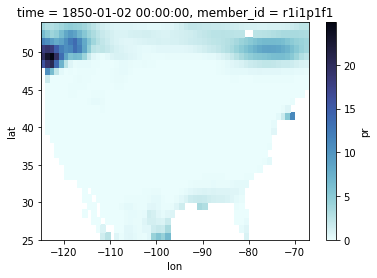

In [14]:
regridded_data.isel(member_id=0,time=1).plot.pcolormesh(cmap=cmocean.cm.ice_r)

# step2: epoch adjustment

In [15]:
regridded_ds.pcp.load()
regridded_data.load()


<xarray.DataArray 'pr' (member_id: 1, time: 60226, lat: 29, lon: 58)>
array([[[[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [4.26570231e+00, 1.00266161e+01, 1.26410442e+01, ...,
          6.47646972e+00, 7.16304224e+00, 6.41251836e+00],
         [6.90666673e-02, 1.01793988e+00, 4.43383798e+00, ...,
          4.98893098e+00, 7.81280801e+00, 8.92693813e+00],
         [1.34844775e-04, 1.68131684e-02, 8.27949492e-02, ...,
          2.70805526e-01, 1.47139119e+00, 4.82563827e+00]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ..

In [16]:
regridded_f_data.sel(time=slice("2040","2069")).load()

<xarray.DataArray 'pr' (member_id: 1, time: 10950, lat: 29, lon: 58)>
array([[[[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [2.58698088e+00, 3.48570670e+00, 4.80578500e+00, ...,
          4.35133388e-01, 4.41571933e-01, 4.27651631e-01],
         [2.97646569e+00, 3.99721037e+00, 4.68388487e+00, ...,
          7.21468402e-01, 6.62194362e-01, 5.73045595e-01],
         [2.52572578e+00, 2.74731472e+00, 2.05971817e+00, ...,
          9.67452560e-01, 8.86468269e-01, 8.00294712e-01]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ..

In [17]:
# calculate the 21-day rolling average over historical periods
mean_pcp_train = regridded_ds.pcp.rolling(time=21, center=True).mean()

# calculate the historical mean slice
annual_mean_pcp_train = mean_pcp_train.groupby('time.dayofyear').mean()

In [18]:
# calculate the 21-day rolling average over control period
mean_pcp_hist = regridded_data.sel(time=slice("1980","2016")).rolling(time=21, center=True).mean()

# calculate the historical mean slice
annual_mean_pcp_hist = mean_pcp_hist.groupby('time.dayofyear').mean()

In [19]:
# calculate the 21-day rolling average over future period
mean_pcp_f = regridded_f_data.sel(time=slice("2040","2069")).rolling(time=21, center=True).mean()

# calculate the historical mean slice
annual_mean_pcp_f = mean_pcp_f.groupby('time.dayofyear').mean()

In [20]:
# epoch adjustment
# for future period
pcp_f_epoch_adjust = regridded_f_data.sel(time=slice("2040","2069")).groupby('time.dayofyear')/ (annual_mean_pcp_f/annual_mean_pcp_hist)


In [21]:
pcp_f_epoch_adjust.load()

<xarray.DataArray (member_id: 1, time: 10950, lat: 29, lon: 58)>
array([[[[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [2.25877872e+00, 3.00802021e+00, 4.06746570e+00, ...,
          3.70339802e-01, 3.95619373e-01, 3.95262729e-01],
         [2.42327111e+00, 3.16911931e+00, 3.72299606e+00, ...,
          5.73027449e-01, 5.63815354e-01, 5.19010957e-01],
         [1.98288221e+00, 2.15738329e+00, 1.65918258e+00, ...,
          7.25133357e-01, 7.03939922e-01, 6.78363650e-01]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
  

# step3: Coarse bias correction
**Need Joe Hamman's input**

In [25]:
from xsd.pointwise_models import PointWiseDownscaler,  QuantileMapper 

In [26]:
class MyQM(QuantileMapper):
    def predict(self, X):
        pass

In [24]:
qm = PointWiseDownscaler(model=MyQM, dim='time')

In [37]:
qm.fit?

Signature: qm.fit(X, y, feature_dim='variable', **fit_params)
Docstring:
Fit the model

Fit all the transforms one after the other and transform the
data, then fit the transformed data using the final estimator.

Parameters
----------
X : xarray.DataArray or xarray.Dataset
    Training data. Must fulfill input requirements of first step of
    the pipeline. If an xarray.Dataset is passed, it will be converted
    to an array using `to_array()`.

y : xarray.DataArray
    Training targets. Must fulfill label requirements for all steps
    of the pipeline.
    
feature_dim : str, optional
    Name of feature dimension. 

**fit_params : dict of string -> object
    Parameters passed to the ``fit`` method of the this model. If the
    model is a sklearn Pipeline, parameters can be passed to each
    step, where each parameter name is prefixed such that parameter
    ``p`` for step ``s`` has key ``s__p``.
File:      ~/xsd/xsd/pointwise_models/core.py
Type:      method


In [81]:
# qm.fit(pcp_h_epoch_adjust.sel(member_id='r2i1p1f1',time=slice("1980","2014")),
#        pcp_train_epoch_adjust.pcp.sel(time=slice("1980","2014")))

# step4: constructed analogues
**Find the best 30 analogues based on climate change impacts**

In [22]:
def flatten_data(data_array):
    len_d,len_lat,len_lon = np.shape(data_array.values)
    df_train = pd.DataFrame(np.reshape(data_array.values,[len_d,len_lat*len_lon]),
                             index=data_array.time.values)
    df_train = df_train.dropna(axis=1)
    return df_train

In [23]:
# preprocess: flatten the domain (2D) into a 1D array

df_train = flatten_data(regridded_ds.pcp)
df_f = flatten_data(pcp_f_epoch_adjust.sel(member_id='r1i1p1f1',time=slice("2040","2069")))

In [24]:
# calculate RMSE using matrix calculation to avoid replicate
# RMSE = (1/n) * sqrt(sum_i((d_i-p_i)^2))

# calculate di*pi
df_cross = df_train.dot(df_f.T)

# calculate di^2
df_train_power_2 = pd.DataFrame(df_train.pow(2).sum(axis=1))
df_train_power_2 = pd.concat([df_train_power_2]*len(df_f),axis=1)
df_train_power_2.columns = df_f.index.values

# calculate pi^2
df_f_power_2 = pd.DataFrame(df_f.pow(2).sum(axis=1))
df_f_power_2 = pd.concat([df_f_power_2]*len(df_train),axis=1).T
df_f_power_2.index = df_train.index.values

# calcuate RMSE
sum_ = df_train_power_2+ df_f_power_2 - df_cross.multiply(2)
rmse = np.sqrt(sum_)/np.shape(df_f)[1]

In [25]:
# for each dayofyear, find start/end day of year

start = np.arange(1,367)-45
start[start<=0] += 365

end = np.arange(1,367)+45
end[end>=366] -= 365

df_index = pd.DataFrame(np.transpose([start,end]),index=np.arange(1,367), columns=['start','end'])

In [63]:
# For each day, find the top 30 best fit
ind = 0

# Look up the start/end day of year based on the table
time_tar = pcp_f_epoch_adjust.time.values[ind]
doy_tar = time_tar.dayofyr
doy_start = df_index.start.loc[doy_tar]
doy_end = df_index.end.loc[doy_tar]

# Sort the rows based on RMSE
df_sel = pd.DataFrame(rmse[time_tar]).sort_values(time_tar)
df_sel['dayofyear']=df_sel.index.dayofyear
df_up = df_sel[(df_sel['dayofyear']<doy_end)|(df_sel['dayofyear']>doy_start)]

# Find 30 best fit with lowest RMSE
time_sel = df_up.index[0:30]

In [64]:
# Find the 30 best fit
top_parttern_coarse =  regridded_ds.pcp.sel(time=time_sel)

top_pattern_fine = ds.pcp.sel(time=time_sel)

In [65]:
# calculate the coefficient
df_coarse = flatten_data(top_parttern_coarse)
df_coarse.index=np.arange(30)
df_coarse.columns=np.arange(len(df_coarse.columns))

# calculate the inverse of a matrix
df_inverse = pd.DataFrame(np.linalg.pinv(df_coarse.dot(df_coarse.T).values))

# calculate the observed dataframe
x = np.ravel(pcp_f_epoch_adjust.sel(member_id='r1i1p1f1', time=time_tar).values)
x = x[~np.isnan(x)]
df_obs = pd.DataFrame(x)

# calculate the coefficient
df_coefficient = (df_inverse.dot(df_coarse)).dot(df_obs)


In [66]:
# find the fine resolution map

# step1: transform coefficient into xr.Dataarray 
ds_coeff = xr.DataArray(np.ravel(df_coefficient.values),dims='time',
                        coords=[top_pattern_fine.time.values])

#step2: calculate the fine resolution
ds_fine_resoluation = (top_pattern_fine*ds_coeff).sum(dim='time')


In [67]:
ds_coarse_resoluation = regridded_f_data.sel(time=time_tar, member_id='r1i1p1f1')

Text(0, 0.5, 'Latitude')

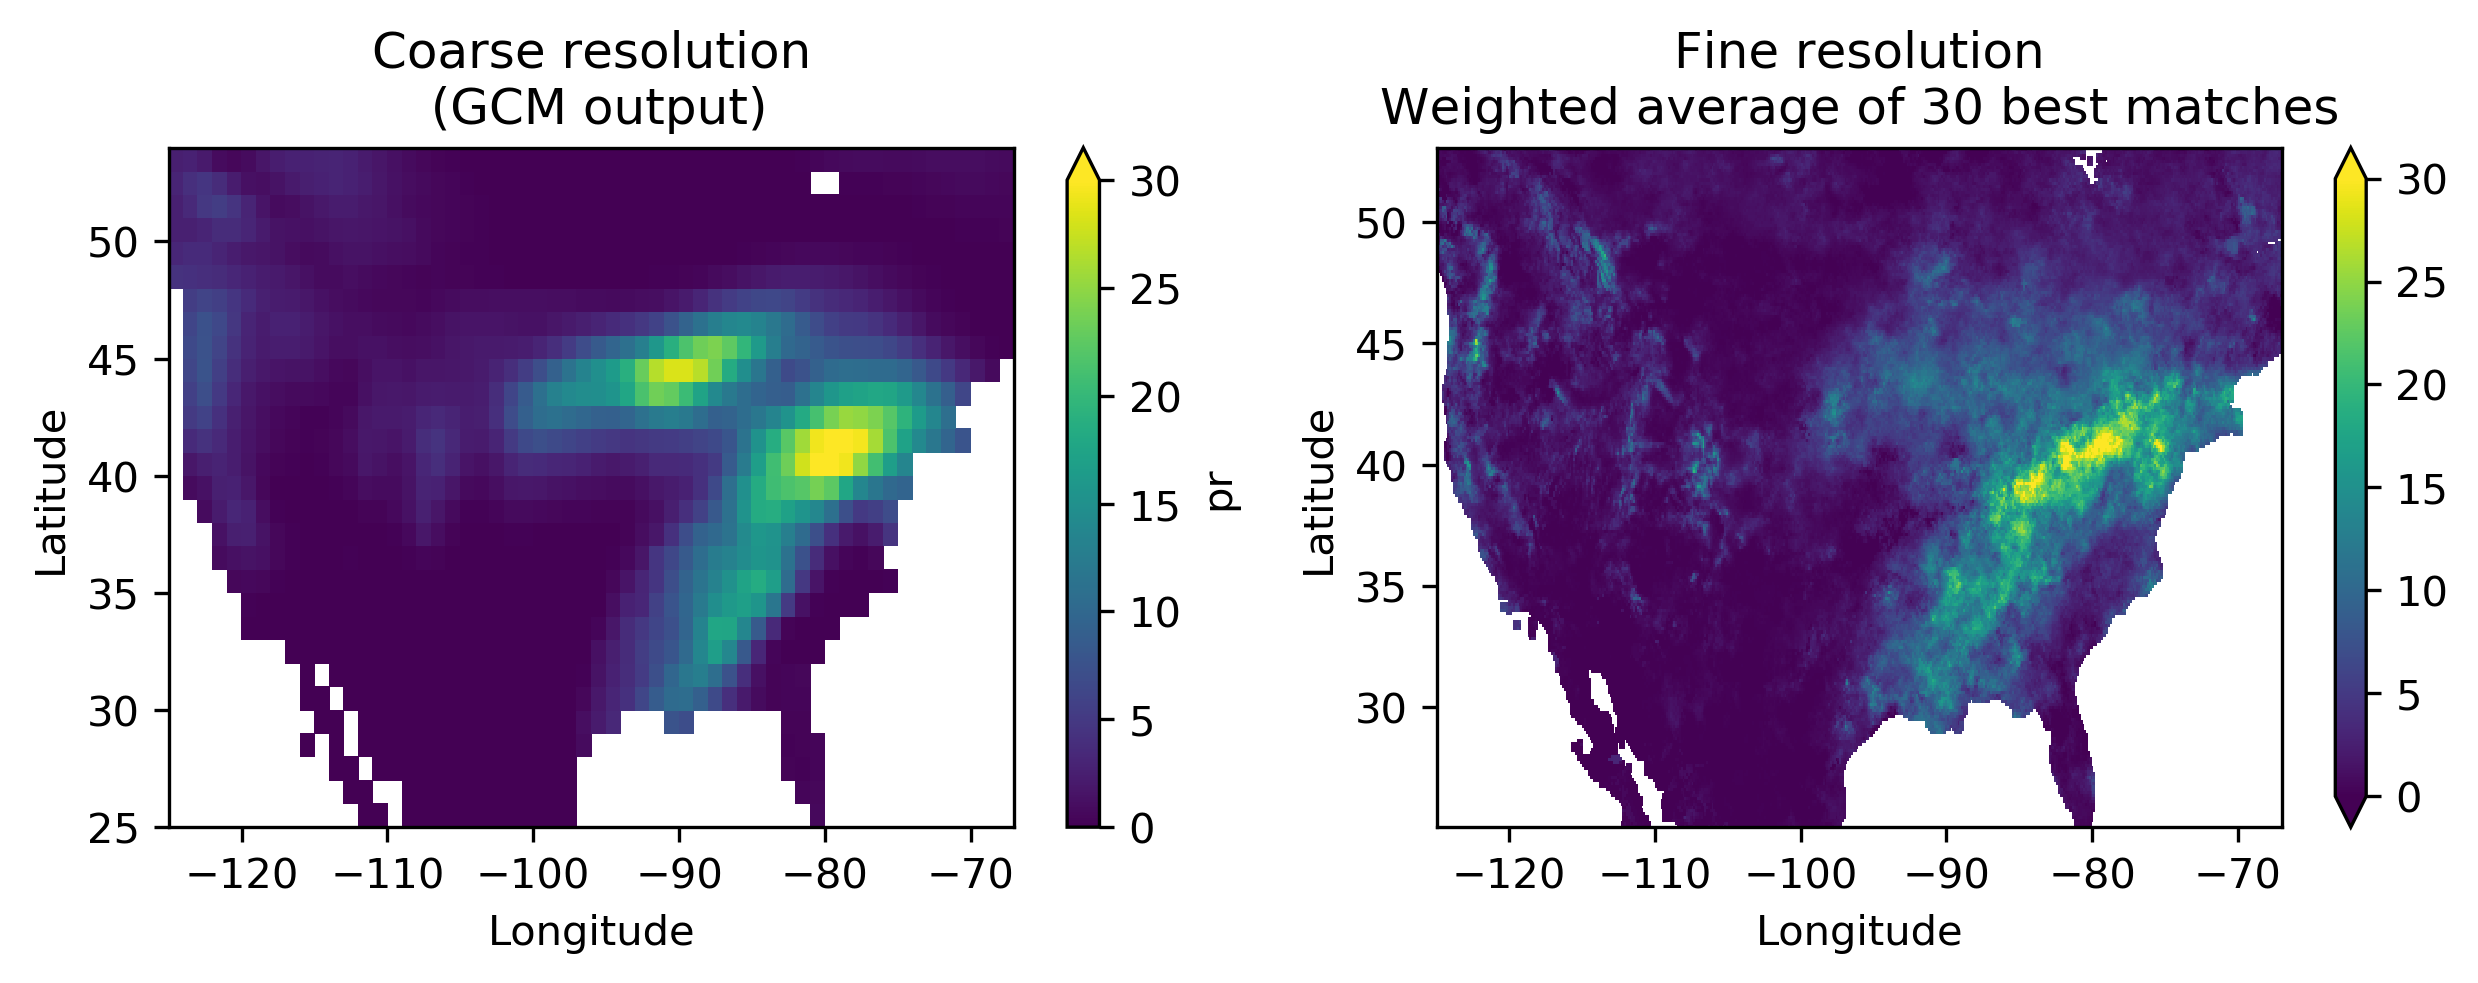

In [70]:
# plot the fine resolution
plt.figure(figsize=[10,3], dpi=300)
plt.subplot(122)
ds_fine_resoluation.where(ds.pcp.isel(time=0)>=0).plot.pcolormesh(vmin=0,vmax=30)
plt.title('Fine resolution\nWeighted average of 30 best matches')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(121)
ds_coarse_resoluation.plot.pcolormesh(vmin=0,vmax=30)
plt.title('Coarse resolution\n (GCM output)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
